In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import exp_utils
import evaluation
from evaluation import generate_ellipse_reference, generate_lemniscate_reference
import script
import flatness
import simulate
from dynamics import PlanarQuadDynamicsWithDrag, PlanarQuadDynamics
import matplotlib.pyplot as plt

In [3]:
quad_params = {
    'm_quad': 1.0,
    'I_quad': 0.1,
    'g': 9.81,
    'F_max': 25.0,
    'tau_max': 0.5,
    'C_pd': [0.1, 0.1],  # Parasitic drag in (x, y) directions
    'C_rdx': 1e-2
}

data_params = {
    # 'num_samples': 5000,
    # 'Tf': 0.3,
    'num_samples': 5000,
    'Tf': 0.3,
    'x_min': torch.tensor([-1, -1, -0.5, -0.5, -0.05, -0.1]),
    # 'u_range': (
    #     torch.tensor((quad_params['g'] * 0.8, -quad_params['tau_max'])),
    #     torch.tensor((quad_params['F_max'], quad_params['tau_max']))
    # ),
    'u_range': (
        torch.tensor((quad_params['g'] * 0.9, -quad_params['tau_max'])),
        torch.tensor((quad_params['g'] * 1.1, quad_params['tau_max']))
    ),
    'obs_noise_std': 0.,
    # 'dt': 1e-2
    'dt': 1e-2
}

training_params = {
    'hidden_dims': [32],
    'batch_size': 128,
    'num_epochs': 20,
    'learning_rate': 4e-3,
}

open_loop_sim_params = {
    'dt': 1e-2,
    'Tref': 14.0,
    'ellipse_axes': [1, 1],
    'lemniscate_axes': [1, 0.6],
    'ref_ang_vel': np.pi / 7
}

closed_loop_sim_params = {
    'dt': 1e-2,
    'Tref': 14.0,
    'ellipse_axes': [1, 1],
    'lemniscate_axes': [1, 0.6],
    'ref_ang_vel': np.pi / 7,
    'obs_noise_std': 1e-3,
    'u_noise_std': torch.tensor([1e-2, 1e-3]),
    'controller_gain': np.array([0.9, 0.91, 0.92, 0.93]),
    'observer_gain': np.array([0.45, 0.55, 0.4, 0.5])
}

In [4]:
seed = 1
nominal_dynamics = PlanarQuadDynamics(**quad_params)
true_dynamics = PlanarQuadDynamicsWithDrag(**quad_params)
# rm = exp_utils.train_models(seed, quad_params, data_params, training_params)
residual_model = exp_utils.load_model(f'./models/residual_model_{seed}.pth', training_params)

In [103]:
# ref = evaluation.generate_ellipse_reference(
#     open_loop_sim_params['ellipse_axes'],
#     open_loop_sim_params['dt'],
#     open_loop_sim_params['Tref'],
#     open_loop_sim_params['ref_ang_vel']
# )
ref = evaluation.generate_lemniscate_reference(
    open_loop_sim_params['lemniscate_axes'],
    open_loop_sim_params['dt'],
    open_loop_sim_params['Tref'],
    open_loop_sim_params['ref_ang_vel']
)

In [14]:
class FakeResidual(nn.Module):
    def __init__(self, quad_params):
        super().__init__()
        self.true_dynamics =  PlanarQuadDynamicsWithDrag(**quad_params)

    def forward(self, x):
        res = torch.cat((torch.zeros_like(x), torch.zeros_like(x[..., :2])), dim=-1)
        res[..., 2:4] += self.true_dynamics.drag(
            torch.cat((x, torch.zeros_like(x[..., :2])), dim=-1)
        )
        return res
fr = FakeResidual(quad_params)

In [201]:
nominal_flat_ctrl = flatness.FlatnessController(
    None, quad_params, ref.numpy(), None, None, open_loop_sim_params['dt']
)
learned_flat_ctrl = flatness.FlatnessController(
    residual_model, quad_params, ref.numpy(), None, None, open_loop_sim_params['dt']
)
true_flat_ctrl = flatness.FlatnessController(
    FakeResidual(quad_params), quad_params, ref.numpy(), None, None, open_loop_sim_params['dt']
)

In [215]:
ctrl = nominal_flat_ctrl

In [216]:
i = np.random.randint(ref.shape[0])

In [217]:
dt = 1e-4
z = ref[i:i+1, :8]
v = ref[i:i+1, 8:]
dz = dt * ref[i:i+1, 2:]

In [218]:
xf = ctrl.z2x_model(z, v)
uf = ctrl.z2u_model(z, v)
x_dot, u_sat = true_dynamics.dot_fn(torch.tensor(xf), torch.tensor(uf))

dx = ctrl.z2x_model(z + dz, v)
dxdt = (dx - xf) / dt

In [219]:
np.set_printoptions(precision=3)

In [220]:
x_dot.numpy()

array([[-0.324, -0.086,  0.133, -0.087,  0.002,  0.023]], dtype=float32)

In [221]:
dxdt

array([[-0.324, -0.086,  0.119, -0.09 ,  0.002,  0.023]], dtype=float32)

In [86]:
x_dot.numpy() - dxdt

array([[-1.062e-04,  3.435e-05, -1.130e-04,  2.065e-05, -2.006e-04,
         1.816e-04]], dtype=float32)

In [309]:
true_x0 = torch.tensor(true_flat_ctrl.z2x_model(*torch.split(ref[:1], 8, dim=-1)))
nominal_u = torch.tensor(nominal_flat_ctrl.z2u_model(*torch.split(ref, 8, dim=-1)))
learned_u = torch.tensor(learned_flat_ctrl.z2u_model(*torch.split(ref, 8, dim=-1)))
true_u = torch.tensor(true_flat_ctrl.z2u_model(*torch.split(ref, 8, dim=-1)))

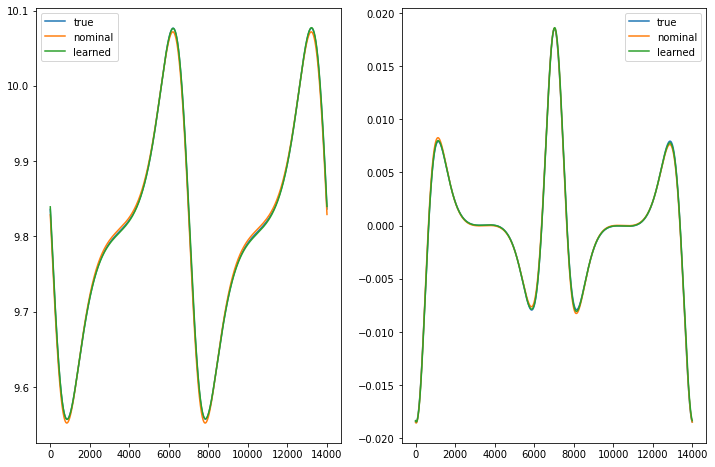

In [310]:
plt.figure(figsize=(12, 8))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(true_u[:, i], label='true')
    plt.plot(nominal_u[:, i], label='nominal')
    plt.plot(learned_u[:, i], label='learned')
    plt.legend()